In [1]:
!pip install transformers

     |████████████████████████████████| 1.3MB 12.3MB/s 
     |████████████████████████████████| 1.1MB 53.4MB/s 
     |████████████████████████████████| 890kB 56.4MB/s 
     |████████████████████████████████| 2.9MB 57.7MB/s 
  Created wheel for sacremoses: filename=sacremoses-0.0.43-cp36-none-any.whl size=893257 sha256=13be446e8e9dbafc6870528ebb6b4eb7501f00c549438785dbe951f97eec7965
  Stored in directory: /root/.cache/pip/wheels/29/3c/fd/7ce5c3f0666dab31a50123635e6fb5e19ceb42ce38d4e58f45
Successfully built sacremoses


In [2]:
# imports
import torch
from torch import nn
from transformers import AutoTokenizer, AutoModelWithLMHead
from matplotlib import pyplot as plt

from google.colab import files
files.upload()  # load dataGeneration.py
files.upload()  # load waypointNet.py
from dataGeneration import generateTestBatch
from waypointNet import WaypointNet, listToTensor

Saving dataGeneration.py to dataGeneration.py


Saving waypointNet.py to waypointNet.py


In [3]:
# import the pretrained models
tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")
model = AutoModelWithLMHead.from_pretrained("bert-base-uncased")

/usr/local/lib/python3.6/dist-packages/transformers/modeling_auto.py:837: FutureWarning: The class `AutoModelWithLMHead` is deprecated and will be removed in a future version. Please use `AutoModelForCausalLM` for causal language models, `AutoModelForMaskedLM` for masked language models and `AutoModelForSeq2SeqLM` for encoder-decoder models.
  FutureWarning,


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [5]:
# investigating BERT model output size
baseModel = model.bert

sampleBatch = ["go forward three meters", "turn right", "go right 1 meter"]
enc = tokenizer.batch_encode_plus(sampleBatch)
X = listToTensor(enc["input_ids"])
attn = listToTensor(enc["attention_mask"])

out = baseModel(X, attn)
print(out[0].shape)
print("Batch size, length of tokenized text, model output size\n")

torch.Size([3, 6, 768])
Batch size, length of tokenized text, model output size



cuda:0
[10] loss: 4.703
[20] loss: 3.998
[30] loss: 2.893
[40] loss: 2.655
[50] loss: 2.497
[60] loss: 2.273
[70] loss: 1.829
[80] loss: 1.789
[90] loss: 1.492
[100] loss: 1.568
[110] loss: 1.361
[120] loss: 1.099
[130] loss: 0.972
[140] loss: 0.807
[150] loss: 0.776
[160] loss: 0.695
[170] loss: 0.627
[180] loss: 0.554
[190] loss: 0.465
[200] loss: 0.452
[210] loss: 0.369
[220] loss: 0.385
[230] loss: 0.363
[240] loss: 0.305
[250] loss: 0.335
[260] loss: 0.293
[270] loss: 0.308
[280] loss: 0.291
[290] loss: 0.263
[300] loss: 0.232
[310] loss: 0.245
[320] loss: 0.264
[330] loss: 0.227
[340] loss: 0.286
[350] loss: 0.207
[360] loss: 0.239
[370] loss: 0.211
[380] loss: 0.179
[390] loss: 0.187
[400] loss: 0.173
[410] loss: 0.216
[420] loss: 0.167
[430] loss: 0.208
[440] loss: 0.155
[450] loss: 0.157
[460] loss: 0.143
[470] loss: 0.155
[480] loss: 0.157
[490] loss: 0.125
[500] loss: 0.153


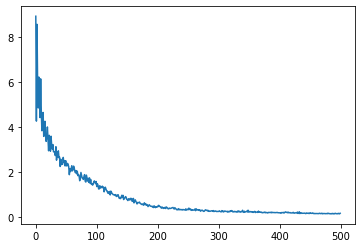

In [7]:
# training model
if torch.cuda.is_available():  
  device = torch.device("cuda:0") 
else:  
  device = torch.device("cpu")
print(device)

net = WaypointNet(baseModel)
net = net.to(device=device)
criterion = nn.MSELoss()
optimizer = torch.optim.SGD(net.parameters(), lr=0.0001, momentum=0.9)
objectiveValues = []

# each epoch is a newly generated batch of test data
for epoch in range(500):
  text, labels = generateTestBatch(1000)
  labels = torch.tensor(labels, dtype = torch.float)
  enc = tokenizer.batch_encode_plus(text)
  X = listToTensor(enc["input_ids"])
  attn = listToTensor(enc["attention_mask"])

  X = X.to(device)
  attn = attn.to(device)
  labels = labels.to(device)

  # zero the parameter gradients
  optimizer.zero_grad()

  # forward + backward + optimize
  outputs = net((X, attn))
  loss = criterion(outputs, labels)
  loss.backward()
  optimizer.step()

  # print statistics
  if ((epoch + 1) % 10 == 0):
    print('[%d] loss: %.3f' % (epoch + 1, loss.item()))
  objectiveValues.append(loss.item())

plt.plot(objectiveValues)

In [ ]:
# save model
torch.save(net.state_dict(), "waypointBERT.pth")
files.download("waypointBERT.pth")